# Using Pyro for Estimation

<div class="alert alert-info">

Note

Currently we are still experimenting Pyro and support Pyro only with LGT.

</div>

[Pyro](https://github.com/pyro-ppl/pyro)  is a flexible, scalable deep probabilistic programming library built on PyTorch.  **Pyro** was originally developed at Uber AI and is now actively maintained by community contributors, including a dedicated team at the Broad Institute. 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import orbit
from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims

In [2]:
assert orbit.__version__ == '1.0.13dev'

In [3]:
df = load_iclaims()

In [4]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## MAP Fit and Predict

To use **Pyro** as the inference engine, one needs to specify the `estimator_type` as `PyroEstimatorMAP` or `PyroEstimatorVI`.

In [5]:
lgt_map = LGTMAP(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=8888,
    estimator_type=PyroEstimatorMAP,
)

In [6]:
%%time
lgt_map.fit(df=train_df)

CPU times: user 10.6 s, sys: 213 ms, total: 10.8 s
Wall time: 10.8 s


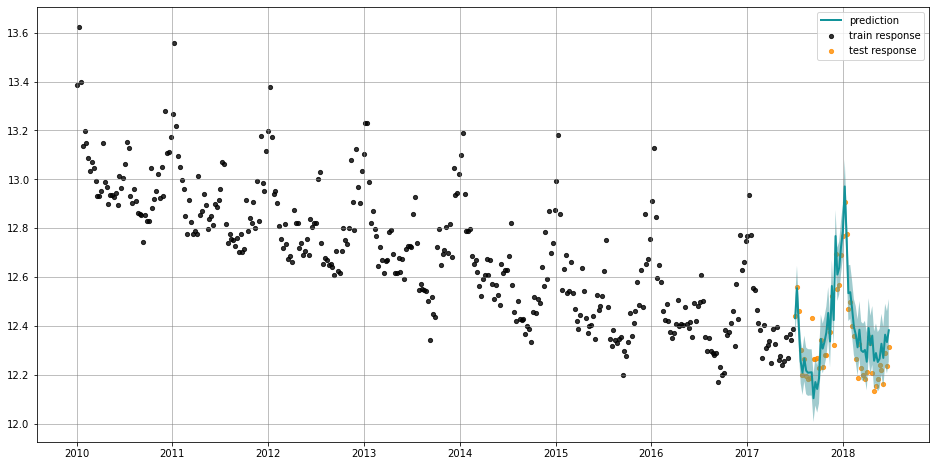

In [7]:
predicted_df = lgt_map.predict(df=test_df)
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, 
                    test_actual_df=test_df)

## VI Fit and Predict

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [8]:
lgt_vi = LGTFull(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    num_steps=101,
    num_sample=100,
    learning_rate=0.1,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI,
)

In [9]:
%%time
lgt_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


CPU times: user 13.4 s, sys: 490 ms, total: 13.9 s
Wall time: 13.5 s


In [10]:
predicted_df = lgt_vi.predict(df=test_df)

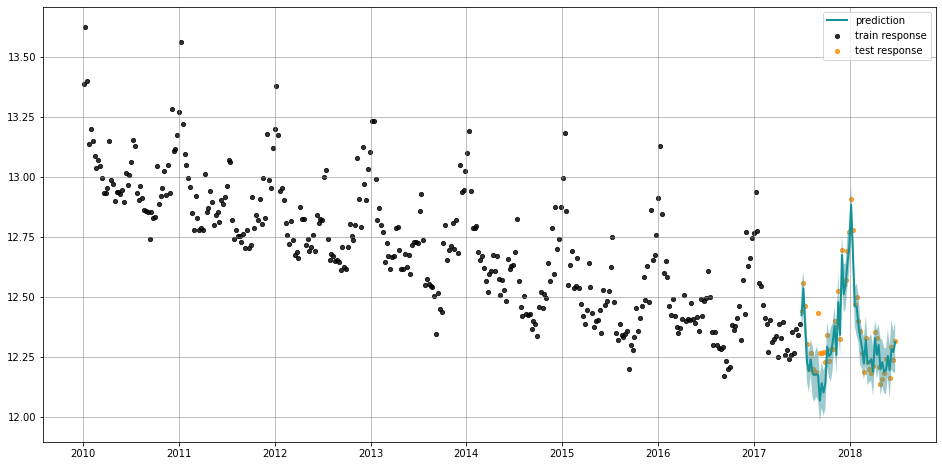

In [11]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_vi.date_col, actual_col=lgt_vi.response_col, 
                    test_actual_df=test_df)